In [1]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cpu - cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd

RAV = '/content/drive/MyDrive/Audio_Speech_Actors_01-24/'
dir_list = os.listdir(RAV)
dir_list.sort()
dir_list[:10]
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

neutral     288
happy       192
sad         192
angry       192
surprise    192
fear        192
disgust     192
Name: emotion, dtype: int64

In [4]:
RAV_df

,gender,emotion,labels,source,path
0,male,neutral,1,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
1,male,happy,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
2,male,neutral,1,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
3,male,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
4,male,neutral,2,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
...,...,...,...,...,...
1435,female,disgust,7,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
1436,female,disgust,7,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
1437,female,disgust,7,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
1438,female,disgust,7,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...


In [5]:
RAV_df = RAV_df[(RAV_df["emotion"]=="neutral") | (RAV_df["emotion"]=="happy") | (RAV_df["emotion"]=="sad") | (RAV_df["emotion"]=="angry")]


In [6]:
# RAV_df = RAV_df.sample(frac=0.1)
train_df = RAV_df.sample(frac=0.8)
test_df = RAV_df.drop(train_df.index)

In [7]:
train_df

,gender,emotion,labels,source,path
1083,male,neutral,2,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
491,male,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
608,male,happy,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
1286,female,neutral,2,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
1272,female,neutral,2,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
...,...,...,...,...,...
1393,female,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
737,male,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
318,female,happy,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...
149,male,happy,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...


In [8]:
train_df["emotion"].value_counts()

neutral    225
angry      163
sad        159
happy      144
Name: emotion, dtype: int64

In [9]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                  male
emotion                                              neutral
labels                                                     2
source                                               RAVDESS
path       /content/drive/MyDrive/Audio_Speech_Actors_01-...
Name: 1083, dtype: object


In [10]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00


In [11]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [12]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

In [13]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

In [14]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [15]:
# Training
import time
from torch.utils.data import DataLoader
from tqdm import tqdm
# Set the number of epoch
epoch = 1

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        # record the loss for each batch
        epoch_loss.append(loss.item())

    pbar.close()

    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)


Epoch 1/1


100%|██████████| 346/346 [2:49:19<00:00, 29.36s/it, Loss=0.965, Accuracy=0.611]


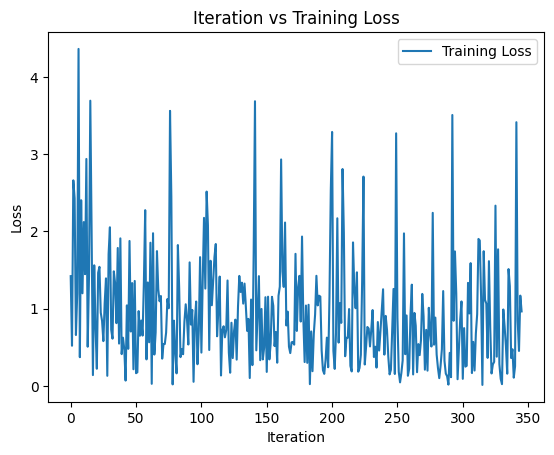

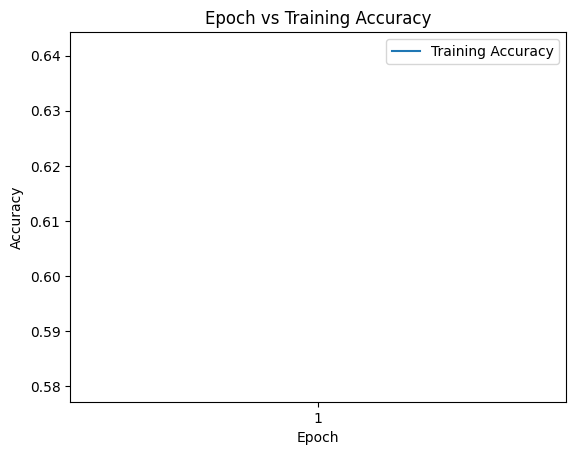

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

In [17]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():

    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}

    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })

        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 173/173 [13:21<00:00,  4.64s/it, loss=0.409, accuracy=0.728]


The final accuracy on the test dataset: 72.8324%


In [18]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]

df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions
df[df["emotion"]!=df["Model Prediction"]]

,index,gender,emotion,labels,source,path,Model Prediction
1,3,male,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,neu
2,5,male,hap,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,sad
3,19,male,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,neu
7,77,female,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,neu
20,181,female,hap,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,neu
22,186,female,neu,2,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,sad
23,189,female,hap,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,neu
35,261,male,hap,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,neu
37,270,male,hap,3,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,sad
40,313,female,sad,4,RAVDESS,/content/drive/MyDrive/Audio_Speech_Actors_01-...,neu


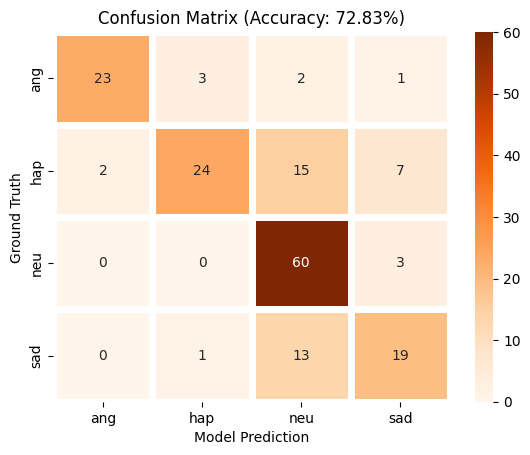

In [19]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()